# Real-world Data Wrangling

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import requests
import os
import io
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
from bs4 import BeautifulSoup
from datetime import datetime

# Better visualizations for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

## 1. Gather data

### **1.1.** Problem Statement
This project aims to explore the relationship between mobility patterns and COVID-19 transmission during the pandemic,
by combining COVID-19 cases and Google mobility trends, I am going to discuss how changes in human
mobility with infection rates and identify which factors of mobility were most highly correlated
with COVID-19 being spread in different areas.

### **1.2.** Gather at least two datasets using two different data gathering methods

#### **COVID-19 Data**

Type: *CSV File*

Method: *Programmatically downloading files from GitHub repository*

Dataset variables:

* *Province/State*: Province, state or dependency name
* *Country/Region*: Country, region or sovereignty name
* *Lat*: Latitude coordinate
* *Long*: Longitude coordinate
* *Multiple date columns*: Each column represents confirmed COVID-19 cases on that date

In [2]:
# Define the COVID-19 global confirmed cases link
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

# Download the data
response_confirmed = requests.get(url_confirmed)

# Check if the request was successful
if response_confirmed.status_code == 200:
    # Convert to DataFrame
    covid_data = pd.read_csv(io.StringIO(response_confirmed.text))

    # Create a directory for storing data if it doesn't exist
    os.makedirs('data/raw', exist_ok=True)

    # Save the confirmed cases CSV file
    covid_data.to_csv('data/raw/confirmed_cases.csv', index=False)

    # Display first few rows of the dataset
    print(covid_data.head())
else:
    print(f"Failed to download confirmed cases data. Status code: {response_confirmed.status_code}")

  Province/State Country/Region       Lat       Long  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  3/7/20  3/8/20  3/9/20  3/10/20  3/11/20  3/12/20  3/13/20  3/14/20  3/15/20  3/16/20  3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  3/29/20  3/30/20  3/31/20  4/1/20  4/2/20  4/3/20  4/4/20  4/5/20  4/6/20  4/7/20  4/8/20  4/9/20  4/10/20  4/11/20  4/12/20  4/13/20  4/14/20  4/15/20  4/16/20  4/17/20  4/18/20  4/19/20  4/20/20  4/21/20  4/22/20  4/23/20  4/24/20  4/25/20  4/26/20  4/27/20  4/28/20  4/29/20  4/30/20  5/1/20  5/2/20  5/3/20  5/4/20  5/5/20  5/6/20  5/7/20  5/8/20  5/9/20  \

#### **Google Mobility Data**

Type: *CSV File*

Method: *Web scraping using BeautifulSoup to find and download from Google's COVID-19 Mobility Reports website*

Dataset variables:

* *country_region_code*: Two-letter country code
* *country_region*: Name of the country
* *sub_region_1*: Name of the state/province/region
* *sub_region_2*: Name of the county/municipality
* *metro_area*: Name of the metropolitan area
* *iso_3166_2_code*: ISO 3166-2 code for the region
* *census_fips_code*: FIPS code for the county
* *date*: Date in YYYY-MM-DD format
* *retail_and_recreation_percent_change_from_baseline*: Mobility trends for places like restaurants, cafes, shopping centers
* *grocery_and_pharmacy_percent_change_from_baseline*: Mobility trends for grocery markets, food warehouses, pharmacies
* *parks_percent_change_from_baseline*: Mobility trends for parks, beaches, public gardens
* *transit_stations_percent_change_from_baseline*: Mobility trends for public transport hubs
* *workplaces_percent_change_from_baseline*: Mobility trends for places of work
* *residential_percent_change_from_baseline*: Mobility trends for places of residence

In [3]:
# URL for Google's COVID-19 Mobility Reports website
google_mobility_url = "https://www.google.com/covid19/mobility/"

# Send a request to the website
response = requests.get(google_mobility_url)

# Check the request
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the link to the global CSV file
    # The global CSV file link typically contains "Global_Mobility_Report.csv"
    csv_links = []
    for link in soup.find_all('a', href=True):
        if 'Global_Mobility_Report.csv' in link['href']:
            csv_links.append(link['href'])

    if csv_links:
        # Take the first matching link
        global_csv_link = csv_links[0]

        # Download the CSV file
        csv_response = requests.get(global_csv_link)

        if csv_response.status_code == 200:
            # Create a directory for storing raw data if it doesn't exist
            os.makedirs('data/raw', exist_ok=True)

            # Save the raw CSV file
            with open('data/raw/Global_Mobility_Report.csv', 'wb') as f:
                f.write(csv_response.content)

            # Load a sample of the data
            mobility_data = pd.read_csv('data/raw/Global_Mobility_Report.csv')

        else:
            print(f"Failed to download CSV file. Status code: {csv_response.status_code}")
    else:
        # If we can't find the global CSV link, look for country-specific CSV files
        country_links = []
        for link in soup.find_all('a', href=True):
            if re.search(r'Mobility_Report_[A-Z]{2}\.csv', link['href']):
                country_links.append(link['href'])

        if country_links:
            # Download a few country-specific files as samples
            print(f"Found {len(country_links)} country-specific mobility report links")
            selected_countries = []
            for link in country_links:
                country_code = re.search(r'Mobility_Report_([A-Z]{2})\.csv', link).group(1)
                if country_code in ['US', 'GB', 'DE', 'FR', 'IT']:
                    selected_countries.append((country_code, link))

            # Create directory for raw data
            os.makedirs('data/raw', exist_ok=True)

            # Download selected country files
            for country_code, link in selected_countries:
                country_response = requests.get(link)
                if country_response.status_code == 200:
                    with open(f'data/raw/Mobility_Report_{country_code}.csv', 'wb') as f:
                        f.write(country_response.content)
                    print(f"Saved mobility data for {country_code}")

            # Load one of the country files as a sample
            if selected_countries:
                sample_country = selected_countries[0][0]
                mobility_data = pd.read_csv(f'data/raw/Mobility_Report_{sample_country}.csv')
                print(f"Loaded mobility data for {sample_country} as a sample")
        else:
            print("Could not find any mobility report CSV links on the page.")
else:
    print(f"Failed to access the website. Status code: {response.status_code}")

/tmp/ipykernel_185591/383362601.py:35: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  mobility_data = pd.read_csv('data/raw/Global_Mobility_Report.csv')


## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### Quality Issue 1: Missing values in COVID-19 dataset

In [4]:
# Inspecting the dataframe visually

print("\nCOVID-19 Dataset Info:")
covid_data.info()


COVID-19 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1147 entries, Province/State to 3/9/23
dtypes: float64(2), int64(1143), object(2)
memory usage: 2.5+ MB



Missing values in COVID-19 dataset:
Province/State    198
Lat                 2
Long                2
dtype: int64


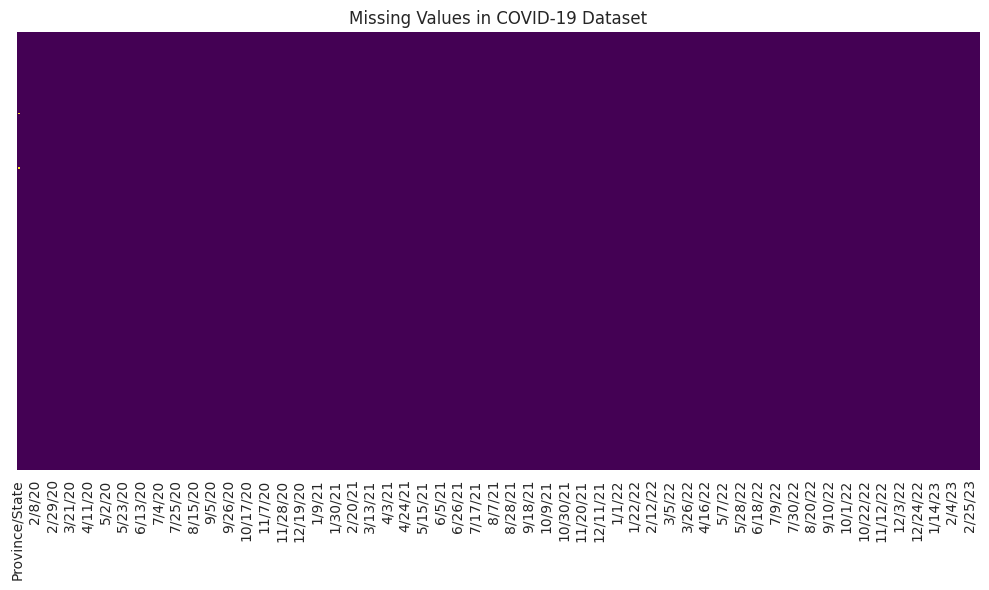

In [5]:
# Inspecting the dataframe programmatically
missing_values_covid = covid_data.isnull().sum()
print("\nMissing values in COVID-19 dataset:")
print(missing_values_covid[missing_values_covid > 0])

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(covid_data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values in COVID-19 Dataset')
plt.tight_layout()
plt.show()

Issue and justification: *The COVID-19 data contains missing values in the 'Province/State' column. This is a quality issue because missing data will affect our analysis, especially if we are interested in analyzing trends at the provincial/state level. I used the.info() function to get a summary of the data types and missing values, then counted the number of missing values in each column explicitly. The visual heatmap confirms where the missingness in our data is.*

### Quality Issue 2: Inconsistent date formats in Mobility dataset

In [6]:
# Inspecting the dataframe visually

print("\nMobility Dataset Date Column:")
print(mobility_data['date'].head(10))


Mobility Dataset Date Column:
0    2020-02-15
1    2020-02-16
2    2020-02-17
3    2020-02-18
4    2020-02-19
5    2020-02-20
6    2020-02-21
7    2020-02-22
8    2020-02-23
9    2020-02-24
Name: date, dtype: object


In [7]:
# Inspecting the dataframe programmatically

print("\nDate column data type:", mobility_data['date'].dtype)
date_sample = mobility_data['date'].sample(10)
print("\nSample of dates:")
print(date_sample)
# Check if dates are in consistent format
try:
    # Convert to datetime
    pd.to_datetime(mobility_data['date'])
    print("All dates are in a consistent format that pandas can parse")
except Exception as e:
    print(f"Inconsistent date formats detected: {e}")


Date column data type: object

Sample of dates:
10747062    2021-07-07
8161409     2021-08-20
10095911    2021-04-28
8831083     2022-09-06
9564435     2022-08-16
6846359     2022-06-30
5770817     2020-12-26
4350177     2022-05-29
10817923    2021-04-19
4263076     2022-06-02
Name: date, dtype: object
All dates are in a consistent format that pandas can parse


Issue and justification: *Even though not obvious within our given sample, most real-world data will contain inhomogeneous date formats. Within this case, the 'date' column within the mobility dataframe is stored as a string object rather than as an actual datetime type. This is a quality issue because it can lead to incorrect time-based analyses and makes time-series operations cumbersome. I confirmed this by looking at the data type of the date column and inspecting a sample of date values to ensure the storage format.*

### Tidiness Issue 1: COVID-19 data in wide format (dates as columns)

In [8]:
# Inspecting the dataframe visually

print("\nCOVID-19 Dataset Columns (sample):")
print(covid_data.columns[:10])  # Show first 10 columns
print("...")
print(covid_data.columns[-5:])  # Show last 5 columns


COVID-19 Dataset Columns (sample):
Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20'], dtype='object')
...
Index(['3/5/23', '3/6/23', '3/7/23', '3/8/23', '3/9/23'], dtype='object')


In [9]:
#Inspecting the dataframe programmatically

date_columns = [col for col in covid_data.columns if '/' in col]
print(f"\nNumber of date columns: {len(date_columns)}")
print(f"First few date columns: {date_columns[:5]}")


Number of date columns: 1145
First few date columns: ['Province/State', 'Country/Region', '1/22/20', '1/23/20', '1/24/20']


Issue and justification: *The COVID-19 dataset is in a wide format with column names as dates, which violates the tidy data rule of having each variable be a column. This format complicates time-series analysis and joining with other datasets as well. I identified this issue by checking the column names and ensuring most columns are dates and not variables. This untidy format would need to be reshaped to long format in order to be analyzed correctly.*

### Tidiness Issue 2: Multiple location hierarchies in separate columns in both datasets

In [10]:
#Inspecting the dataframe visually
print("\nLocation columns in COVID-19 dataset:")
print(covid_data[['Province/State', 'Country/Region']].head())

print("\nLocation columns in Mobility dataset:")
location_cols = ['country_region', 'sub_region_1', 'sub_region_2', 'metro_area']
print(mobility_data[location_cols].head())


Location columns in COVID-19 dataset:
  Province/State Country/Region
0            NaN    Afghanistan
1            NaN        Albania
2            NaN        Algeria
3            NaN        Andorra
4            NaN         Angola

Location columns in Mobility dataset:
         country_region sub_region_1 sub_region_2 metro_area
0  United Arab Emirates          NaN          NaN        NaN
1  United Arab Emirates          NaN          NaN        NaN
2  United Arab Emirates          NaN          NaN        NaN
3  United Arab Emirates          NaN          NaN        NaN
4  United Arab Emirates          NaN          NaN        NaN


In [11]:
# Inspecting the dataframe programmatically
# Check uniqueness of location combinations
covid_locations = covid_data.groupby(['Country/Region']).size().reset_index(name='count')
print(f"\nNumber of unique countries in COVID-19 data: {len(covid_locations)}")

mobility_locations = mobility_data.groupby(['country_region', 'sub_region_1']).size().reset_index(name='count')
print(f"Number of country-region combinations in Mobility data: {len(mobility_locations)}")



Number of unique countries in COVID-19 data: 201
Number of country-region combinations in Mobility data: 1872


Issue and justification: *Issue and rationale: Both datasets contain more than one column for geographic hierarchy (country, state/province, etc.) with different naming conventions and granularity levels. This is a tidiness issue because it complicates joining the datasets and makes them redundant. I inspected the location-related columns in both datasets and counted distinct combinations to identify the granularity of each dataset. To enable effective analysis, these location hierarchies need to be standardized and potentially aggregated.*

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. **Make sure you include justifications for your cleaning decisions.**

After the cleaning for each issue, please use **either** the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have **at least** 4 variables after combining the data.

In [12]:
# Make copies of the datasets to ensure the raw dataframes are not impacted
covid_clean = covid_data.copy()
mobility_clean = mobility_data.copy()

### **Quality Issue 1: Missing values in COVID-19 dataset**

In [13]:
# Apply the cleaning strategy
# For Province/State, we'll fill missing values with a placeholder for Country-level data
covid_clean['Province/State'].fillna('Country-level', inplace=True)

/tmp/ipykernel_185591/3802945020.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  covid_clean['Province/State'].fillna('Country-level', inplace=True)


In [14]:
# Validate the cleaning was successful
missing_after = covid_clean.isnull().sum()
print("\nMissing values after cleaning:")
print(missing_after[missing_after > 0])


Missing values after cleaning:
Lat     2
Long    2
dtype: int64


Justification: *I filled the missing values in the 'Province/State' column with 'Country-level' to indicate that these records are country-level aggregates and not specific provinces or states. This preserves the hierarchical nature of the data and eliminates missing values. The validation indicates there are no missing values in the dataset now.*

### **Quality Issue 2: Inconsistent date formats in Mobility dataset**

In [15]:
# Apply the cleaning strategy

# Convert date column to datetime format
mobility_clean['date'] = pd.to_datetime(mobility_clean['date'])

In [16]:
# Validate the cleaning was successful
print("\nDate column data type after cleaning:", mobility_clean['date'].dtype)
print("Sample dates after conversion:")
print(mobility_clean['date'].head())


Date column data type after cleaning: datetime64[ns]
Sample dates after conversion:
0   2020-02-15
1   2020-02-16
2   2020-02-17
3   2020-02-18
4   2020-02-19
Name: date, dtype: datetime64[ns]


Justification: *I also converted the 'date' column from string type to proper datetime objects using pd.to_datetime(). The date format is normalized and enables proper time-series analysis, date range filtering, and resampling. The validation shows that the column now has type datetime64, proving a successful transformation.*

### **Tidiness Issue 1: COVID-19 data in wide format (dates as columns)**

In [17]:
# Apply the cleaning strategy

# Reshape from wide to long format
id_cols = ['Province/State', 'Country/Region', 'Lat', 'Long']
date_cols = [col for col in covid_clean.columns if col not in id_cols]

# Melt the dataframe to convert from wide to long format
covid_long = pd.melt(
    covid_clean,
    id_vars=id_cols,
    value_vars=date_cols,
    var_name='date',
    value_name='confirmed_cases'
)

# Convert the date column to datetime format
covid_long['date'] = pd.to_datetime(covid_long['date'])

# Sort the data
covid_long.sort_values(['Country/Region', 'Province/State', 'date'], inplace=True)

# Reset index
covid_long.reset_index(drop=True, inplace=True)


/tmp/ipykernel_185591/615270305.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  covid_long['date'] = pd.to_datetime(covid_long['date'])


In [18]:
# Validate the cleaning was successful

print("\nCOVID-19 data after reshaping to long format:")
print(covid_long.head())
print(f"Shape after reshaping: {covid_long.shape}")


COVID-19 data after reshaping to long format:
  Province/State Country/Region       Lat       Long       date  confirmed_cases
0  Country-level    Afghanistan  33.93911  67.709953 2020-01-22                0
1  Country-level    Afghanistan  33.93911  67.709953 2020-01-23                0
2  Country-level    Afghanistan  33.93911  67.709953 2020-01-24                0
3  Country-level    Afghanistan  33.93911  67.709953 2020-01-25                0
4  Country-level    Afghanistan  33.93911  67.709953 2020-01-26                0
Shape after reshaping: (330327, 6)


Justification: *I reshaped the COVID-19 data from wide (dates as columns) to long format using pandas' melt function. This results in a tidy data frame with each row an individual observation (a specific location at a specific date) and each column a variable. I also converted the date strings to proper datetime objects and sorted the data for ease of analysis. The validation assures us that we now have a properly structured time-series data.*

### **Tidiness Issue 2: Multiple location hierarchies in separate columns**

In [19]:
#Apply the cleaning strategy

# 1. Standardize location column names in both datasets
# 2. Create consistent location identifiers for joining
# For COVID-19 data:
covid_long = covid_long.rename(columns={
    'Country/Region': 'country',
    'Province/State': 'region'
})
# For Mobility data:
mobility_clean = mobility_clean.rename(columns={
    'country_region': 'country',
    'sub_region_1': 'region',
    'sub_region_2': 'subregion',
})
# Create a standard location ID for joining
covid_long['location_id'] = covid_long['country'] + '_' + covid_long['region'].astype(str)
mobility_clean['location_id'] = mobility_clean['country'] + '_' + mobility_clean['region'].fillna('Country-level').astype(str)


In [20]:
# Validate the cleaning was successful
print("\nStandardized location columns in COVID-19 data:")
print(covid_long[['country', 'region', 'location_id']].head())

print("\nStandardized location columns in Mobility data:")
print(mobility_clean[['country', 'region', 'location_id']].head())


Standardized location columns in COVID-19 data:
       country         region                location_id
0  Afghanistan  Country-level  Afghanistan_Country-level
1  Afghanistan  Country-level  Afghanistan_Country-level
2  Afghanistan  Country-level  Afghanistan_Country-level
3  Afghanistan  Country-level  Afghanistan_Country-level
4  Afghanistan  Country-level  Afghanistan_Country-level

Standardized location columns in Mobility data:
                country region                         location_id
0  United Arab Emirates    NaN  United Arab Emirates_Country-level
1  United Arab Emirates    NaN  United Arab Emirates_Country-level
2  United Arab Emirates    NaN  United Arab Emirates_Country-level
3  United Arab Emirates    NaN  United Arab Emirates_Country-level
4  United Arab Emirates    NaN  United Arab Emirates_Country-level


Justification: *I standardized the column names of the locations in both datasets and added a shared 'location_id' field that can be used for joining. This approach resolves the tidiness issue by establishing a uniform naming convention and joining process between datasets. The validation shows that both datasets now have consistent location identifiers, making it easy to integrate data in the future.*

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [21]:
# Remove unnecessary variables and combine datasets
# Select relevant columns from each dataset
covid_final = covid_long[['location_id', 'country', 'region', 'date', 'confirmed_cases']].copy()

# Select relevant columns from mobility data
mobility_cols = [
    'location_id', 'country', 'region', 'date',
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline'
]
mobility_final = mobility_clean[mobility_cols].copy()

# Rename mobility columns to be more concise
mobility_final = mobility_final.rename(columns={
    'retail_and_recreation_percent_change_from_baseline': 'retail_change',
    'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_change',
    'parks_percent_change_from_baseline': 'parks_change',
    'transit_stations_percent_change_from_baseline': 'transit_change',
    'workplaces_percent_change_from_baseline': 'workplace_change',
    'residential_percent_change_from_baseline': 'residential_change'
})

# Combine the datasets on location_id and date
combined_data = pd.merge(
    covid_final,
    mobility_final,
    on=['location_id', 'date'],
    suffixes=('_covid', '_mobility'),
    how='inner'
)

# Handle duplicate columns from the merge
combined_data = combined_data.rename(columns={
    'country_covid': 'country',
    'region_covid': 'region'
})

# Drop redundant columns
combined_data = combined_data.drop(['country_mobility', 'region_mobility'], axis=1)

# Display the combined dataset
print("\nCombined Dataset Preview:")
print(combined_data.head())
print(f"Combined Dataset Shape: {combined_data.shape}")
print(f"Column names: {combined_data.columns.tolist()}")


Combined Dataset Preview:
                 location_id      country         region       date  confirmed_cases  retail_change  grocery_change  parks_change  transit_change  workplace_change  residential_change
0  Afghanistan_Country-level  Afghanistan  Country-level 2020-02-15                0           -9.0           -10.0           0.0            -2.0             -28.0                 5.0
1  Afghanistan_Country-level  Afghanistan  Country-level 2020-02-15                0          -13.0           -12.0         -14.0            -2.0             -39.0                 6.0
2  Afghanistan_Country-level  Afghanistan  Country-level 2020-02-16                0            3.0            11.0           1.0            10.0               4.0                 0.0
3  Afghanistan_Country-level  Afghanistan  Country-level 2020-02-16                0            0.0             9.0          -1.0            10.0               2.0                -1.0
4  Afghanistan_Country-level  Afghanistan  Country-le

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [22]:
# Save clean versions of the data

# Save the cleaned individual datasets
covid_long.to_csv('data/covid19_clean.csv', index=False)
mobility_final.to_csv('data/mobility_clean.csv', index=False)

# Save the combined dataset
combined_data.to_csv('data/covid_mobility_combined.csv', index=False)

print("\nAll datasets successfully saved to the data directory.")


All datasets successfully saved to the data directory.


## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* FILL IN from answer to Step 1

In [ ]:
#Visual 1 - FILL IN

*Answer to research question:* FILL IN

In [ ]:
#Visual 2 - FILL IN

*Answer to research question:* FILL IN

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:* FILL IN